#  Comparison of advective and diffusive processes for the vertical dynamics of microplastics

In this work, we looked at the vertical profiles with the results of diffusive modelling carried out under NEMO and advective modelling carried out under ARIANE. The first part represents a global view of the distribution of tracers (diffusive experiment) and particles (advective experiments) and the second part is a regional experiment in 3 distinct areas of the Atlantic Ocean. Master work at the LOPS Brest.

Experiment parameters:
- "NEMO": Concentration of tracers at 1 over the entire ocean surface (global) / in the 3 zones considered (regional)
- "ARIANE": Particles randomly distributed over the surface 2x107 particles globally and 2x103 per zone.

Contacts : 
- anne.gaymard@ifremer.fr 
- claude.talandier@ifremer.fr 
- thierry.huck@univ-brest.fr 
- florian.sevellec@univ-brest.fr 

In [1]:
#####################################
## modules et bibliothèques python ##
#####################################
# Import library
import numpy as np
import xarray as xr
from netCDF4 import Dataset

from matplotlib import pyplot as plt
#import matplotlib as mpl∫
#from matplotlib import cm
#from colorspacious import cspace_converter
#import matplotlib.colors
#import matplotlib.dates as mpd
from mpl_toolkits.basemap import Basemap

import os
import sys
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import random
import statistics
from sklearn.linear_model import LinearRegression
import warnings

In [2]:
# Get the data for the grid
dir = '/gpfswork/rech/hjl/uab91nb/'
file_grid = 'Script/eORCA025.L75_mesh_mask_closed_seas_greenland.nc'
ds_grid = xr.open_dataset(dir+file_grid)
ds_grid

# Depth array
depth_values = ds_grid.nav_lev.values

# Parameters of the grid 
nx = ds_grid.nav_lon.shape[1]
ny = ds_grid.nav_lat.shape[0] 
nz = ds_grid.nav_lev.shape[0] 

ds_grid

<xarray.Dataset>
Dimensions:       (y: 1207, x: 1442, nav_lev: 75, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) float64 0.0
Dimensions without coordinates: y, x
Data variables: (12/51)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ...            ...
    e3uw_0        (time_counter, nav_lev, y, x) float64 ...
    e3vw_0        (time_counter, nav_lev, y, x) float64 ...
    gdept_1d      (time_counter, nav_lev) float64 ...
    gdepw_1d      (time_counter, nav_lev) float64 ...
    gdept_0       (time_counter, nav_lev, y, x) float64 ...
    gdepw_0       (time_counter, nav_lev, y, x) float64 ...
Attributes:
    file_name:  mesh_mask.nc
    TimeStamp:  09/04/2021 19:22:15 +0200

In [3]:
# Functions used 

ds_grid_renamed = ds_grid.rename(nav_lev='deptht')

# Calculate Profiles
def profil_vert_t(data, time):
    profil = data[time,:,:,:].mean(dim=["y","x"], skipna=True)
    return profil

def profiles_vert(data):
    profil = data[:,:,:,:].mean(dim=["y","x"], skipna=True)
    return profil

# Calculate Barycenter 
"""
def barycentre_vert(z,profiles):
    bary = -depth_values * ds_profiles.MyTrc[it, :]
    ctot = ds_profiles.MyTrc[it, :]*ds_grid_renamed.e3t_1d[0,:]
    bary = bary.sum(dim=['deptht'],skipna=True) / ctot.sum(skipna=True)
    return bary
"""
def barycentre_vert(z,profiles):
    bary = z * profiles
    bary = bary.sum(dim=['deptht'],skipna=True) / (profiles.sum(skipna=True))
    return bary

def barycentre_vert_L(z, profiles):
    bary = z * profiles
    bary = bary.sum(dim=['nav_lev'],skipna=True) / np.nansum(profiles)
    return bary

# Calculate Variance
def variance(profiles, barycent, e3t, z, time):
    Ctot = profiles * e3t
    Ctot = Ctot.sum(dim=['deptht'], skipna=True)
    
    sigma2 = np.empty(time)
    for it in range(time):
        nom = profiles[it, :] * (-z - barycent[it])**2 * e3t
        sigma2[it] = nom.sum(dim=['deptht'], skipna=True) / Ctot[it]
    
    return sigma2

# Regression and prediction
def regression(sigma2, time):
    reg = LinearRegression().fit(time, sigma2)
    k = reg.coef_[0]/86400 # unit: m²/s
    var_pred = reg.predict(time)
    return k, var_pred

# Results from the NEMO Simulation - Eulerien

In [5]:
## Vertical profiles with time scale it
file_ts = 'eORCA025.L75_GLOBAL/eORCA025.L75-OFF-Exp1-S/1ts_OUTPUT/eORCA025.L75-OFF-Exp1_y2000m01.1ts_20000101.nc'
ds_ts = xr.open_mfdataset(dir+file_ts)


In [8]:
# Get only few profiles
sub_trc = ds_ts.MyTrc[0:181:18,:,:,:]
profiles = profiles_vert(sub_trc)*ds_grid_renamed.e3t_1d[0]

In [ ]:
barycent = np.zeros(10)

for i in range(10):
    barycent[i] = barycentre_vert(-ds_ts.deptht,profiles[i,:])

In [6]:
%%time
# Moyenne de la concentration sur chaque couche 
# Visualiser les valeurs : graph y -> depth et x-> concentration 

warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in true_divide")

sub_trc = ds_ts.MyTrc[0:181:18,:,:,:]
profiles = profiles_vert(sub_trc)*ds_grid_renamed.e3t_1d[0]

barycent = np.zeros(10)

for i in range(10):
    barycent[i] = barycentre_vert(-ds_ts.deptht,profiles[i,:])

num_profiles = len(profiles)
cmap = plt.cm.Spectral_r
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

plt.figure(figsize=(10,6))
for i in range(0,10):
    plt.plot(profiles[i,:],-depth_values,label=f'{i*21600}s', linewidth=1.5, color=colors[i])
    plt.axhline(barycent[i], linestyle='--', color=colors[i])
plt.legend(fontsize=15)
plt.title('VERTICAL PROFILES FOR DIFFERENT TIME STEPS', fontsize=25)
plt.ylabel('Depth (m)', fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-200,0)
plt.xlabel('Concentration for passive tracers', fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Vert_profils_ORCA025.png')

NameError: name 'sub_trc' is not defined

In [4]:
## Read Data ##
file_ini = 'eORCA025.L75_GLOBAL/eORCA025.L75-OFF-Exp1-S/1ts_global/eORCA025.L75-OFF-Exp1_y2000m01.1ts_20000101.nc'
file = 'eORCA025.L75_GLOBAL/eORCA025.L75-OFF-Exp1-S/1d_global/20??/eORCA025.L75-OFF-Exp1_*.nc'

ds = xr.open_mfdataset(dir+file)
ds_ini = xr.open_dataset(dir+file_ini)
ds

<xarray.Dataset>
Dimensions:               (y: 1207, x: 1442, deptht: 75, time_counter: 4018,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2000-01-01T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(31, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    MyTrc                 (time_counter, deptht, y, x) float32 dask.array<chunksize=(31, 75, 1207, 1442), meta=np.ndarray>
Attributes:
    description:  passive tracers variables
    title:        passive tracers variables
    Conventions:  CF-1.6
    uuid:         9a46a36f-b507-43d7-953a-0cabd58c5f96

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


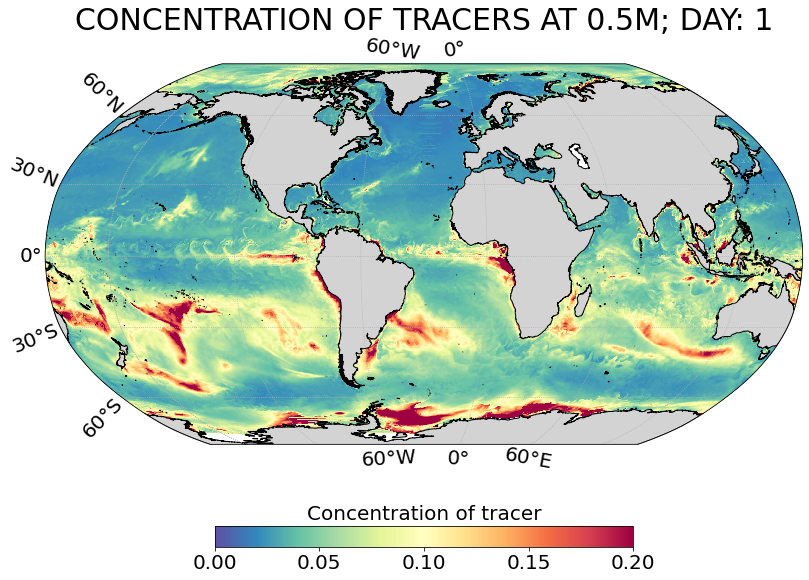

In [12]:
#from mpl_toolkits.basemap import Basemap, shiftgrid
#----------------------------------------------------------------
# Plot data
#----------------------------------------------------------------

time_step = 0
i_depth = 0

def Robin_plot_cartopy(data, time_step, i_depth):
    
    # Set style 
    #------------------------------------------------
    land_10m = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='10m',
        edgecolor='k',
        facecolor='lightgrey')
    
    # Data 
    #------------------------------------------------
    trc = data["MyTrc"][time_step,i_depth,:,:].values
    lon = data["nav_lon"].values
    lat = data["nav_lat"].values
    
    lon = ((lon+180) % 360) - 180

    # Plot
    #------------------------------------------------
    plt.figure(figsize=(15,10))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-30))

    ax.add_feature(land_10m)
    gl = ax.gridlines(linestyle=':',draw_labels=True)
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    map = ax.pcolormesh(lon, lat, trc, transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(map, orientation='horizontal', shrink=0.5)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_title('Concentration of tracer', fontsize=20)
    #map.set_clim(vmin=0, vmax=1)
    map.set_clim(vmin=0, vmax=0.2)
    ax.set_title(f'CONCENTRATION OF TRACERS AT {data.deptht.values[i_depth]:0.1}M; DAY: {time_step+1}',fontsize=30)
    #ax.set_title(f'CONCENTRATION OF TRACERS AT {data.deptht.values[i_depth]:0.1}M; INITIAL TIME',fontsize=30)
    #ax.set_title(f'CONCENTRATION OF TRACERS AT {data.deptht.values[i_depth]:0.1}M; 5 YEARS',fontsize=30)
    plt.savefig(f'Results/Glob_map_E_it{time_step}.png')
    
#----------------------------------------------------------------

def Robin_plot_basemap(data, time_step, i_depth):
    trc = data["MyTrc"][time_step,i_depth,:,:].values
    lon = data["nav_lon"].values
    lat = data["nav_lat"].values
    
    #------------------------------------------------
    plt.figure(figsize=(15,10))
    
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawcoastlines()
    m.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,90.,30.),labels=[0,1,0,0],fontsize=15)
    m.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,1,1],fontsize=15)
    
    # convert lat-lon to projection coordinate system
    lon = ((lon+180) % 360) - 180
    Lon,Lat = m(lon, lat) # convert to projection map

    Lon_order = np.argsort(Lon, axis = 1) ##computing new order of lons
    Lat_order = np.argsort(Lat, axis = 0) ## ... and lats (maybe unnecessary)

    fig = m.pcolormesh(Lon[Lat_order,Lon_order], Lat, trc[Lat_order,Lon_order], cmap=plt.cm.Spectral_r)
    #fig = m.pcolormesh(Lon, Lat, trc, cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(fig,orientation='horizontal',shrink=0.5)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_title('Concentration of tracer', fontsize=20)
    #map.set_clim(vmin=0, vmax=1)
    plt.title(f'The concentration of tacers at {data.deptht.values[i_depth]:0.4}m for day: {time_step+1}',fontsize=30)
    plt.savefig(f'Results/Concentration_tacers_it{time_step}_NEMO.png')


Robin_plot_cartopy(ds, time_step, i_depth)

## Verification of the concentration of tracers

In [ ]:
#----------------------------------------------------------------
# Paramèters 
#----------------------------------------------------------------

t_max = 5
dt = 1
vt = np.arange(0,t_max,dt)

# Create new coordinates from variable 
ds_grid = ds_grid.set_coords(['time_counter', 'nav_lev', 'nav_lat', 'nav_lon'])

# Add the tmask and tmaskutil to the dataset grid 
ds_grid['MyTrc'] = (['sub_time','z','y','x'],np.array(ds.MyTrc[vt,:,:,:]))


In [1]:
#----------------------------------------------------------------
# Volum integration to get the dry mass of tracers
#----------------------------------------------------------------

def inte_volum(trc, e1t, e2t, e3t, vt):
    """
    Data :  trc : concentration from ds 
            et1  : longitude form ds_grid
            et2  : latitude form ds_grid
            et3  : depth form ds_grid
    Return : inte_value : volum integration 
             inte_hor   : horizontal integration    
    """
    # Horizontal integration 
    prod_hor = trc * e1t * e2t
    inte_hor = prod_hor.sum(dim=["x","y"], skipna=True)  
    
    # Vertical integration 
    inte_value = np.zeros(len(vt))
    for t in range(len(vt)):
        for i in range(len(e3t)):
            inte = e3t.values[i]*inte_hor[t,i]
            inte_value[t] += inte
    return inte_value, inte_hor

#----------------------------------------------------------------

def inte_volum_xr(trc, e1t, e2t, e3t):
    """
    Integration with xarray using grid data
    Data :  trc : concentration from ds_grid 
            et1  : longitude form ds_grid
            et2  : latitude form ds_grid
            et3  : depth form ds_grid
    Return : inte : volum integration    
    """
    prod = trc * e1t * e2t * e3t
    inte = prod.sum(dim=["x","y","z"], skipna=True)
    return inte

#----------------------------------------------------------------

def inte_volum_mk(trc, ds_grid):
    """
    Integration with xarray using mask data
    Data :  trc : concentration from ds_grid 
            ds_grid : mask information
    Return : inte : volum integration    
    """
    sub_trc = trc * ds_grid.tmask[0,:,:,:] * ds_grid.e3t_0
    sumZtrc = sub_trc.sum(dim=["z"], skipna=True)
    sub_trc_mk = sumZtrc * ds_grid.tmaskutil[0,:,:] * ds_grid.e1t * ds_grid.e2t
    inte = sub_trc_mk.sum(dim=["y","x"], skipna=True)
    return inte


In [9]:
ds.MyTrc

<xarray.DataArray 'MyTrc' (time_counter: 31, deptht: 75, y: 1207, x: 1442)>
[4046648550 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  (time_counter) datetime64[ns] 2000-01-01T12:00:00 ... 2000...
  * time_counter   (time_counter) datetime64[ns] 2000-01-01T12:00:00 ... 2000...
Dimensions without coordinates: y, x
Attributes:
    long_name:           My own PP
    units:               -
    online_operation:    average
    interval_operation:  1200 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 1200 s)

In [1]:
#sub_trc = ds.MyTrc[0:2,:,:,:]
start = 1
end = 2

#prod = ds.MyTrc.sel(time_counter=slice(start, end)) * ds_grid.e1t * ds_grid.e2t * ds_grid.e3t_0
prod = ds.MyTrc.sel * ds_grid.e1t * ds_grid.e2t * ds_grid.e3t_0
#inte_mk = inte_volum_mk(sub_trc, ds_grid)

#plt.plot(vt, inte_mk)
#plt.title('Conservation of tracers during time iteration')
#plt.xlabel('Iteration time')
#plt.ylabel('Dry mass of tracers')
#plt.grid()
#plt.tight_layout()
#plt.savefig('Tracer_conservation.png')

"\n#sub_trc = ds.MyTrc[0:2,:,:,:]\nstart = 1\nend = 2\n\n#prod = ds.MyTrc.sel(time_counter=slice(start, end)) * ds_grid.e1t * ds_grid.e2t * ds_grid.e3t_0\nprod = ds.MyTrc.sel * ds_grid.e1t * ds_grid.e2t * ds_grid.e3t_0\n#inte_mk = inte_volum_mk(sub_trc, ds_grid)\n\n#plt.plot(vt, inte_mk)\n#plt.title('Conservation of tracers during time iteration')\n#plt.xlabel('Iteration time')\n#plt.ylabel('Dry mass of tracers')\n#plt.grid()\n#plt.tight_layout()\n#plt.savefig('Tracer_conservation.png')\n"

## Vertical profils

In [42]:
# Only for the figure 
#--------------------

# Get the différente time needed in days
Time_array = np.array([1,5,10,31])
Time_array_nemo = Time_array - 1
depth_values = ds.deptht.values

profil_ini = profil_vert_t(ds_ini["MyTrc"], 0)

# Get the data for the time scale 
all_profiles_name = {}
barycenter_name = {}

for t in Time_array_nemo:
    profil_name = f"profiles_{t+1}"
    bary_name =f"baryce_{t+1}"
    
    all_profiles_name[profil_name] = profil_vert_t(ds["MyTrc"], t)*ds_grid_renamed.e3t_1d[0]
    barycenter_name[bary_name] = barycentre_vert(-ds.deptht,all_profiles_name[profil_name])

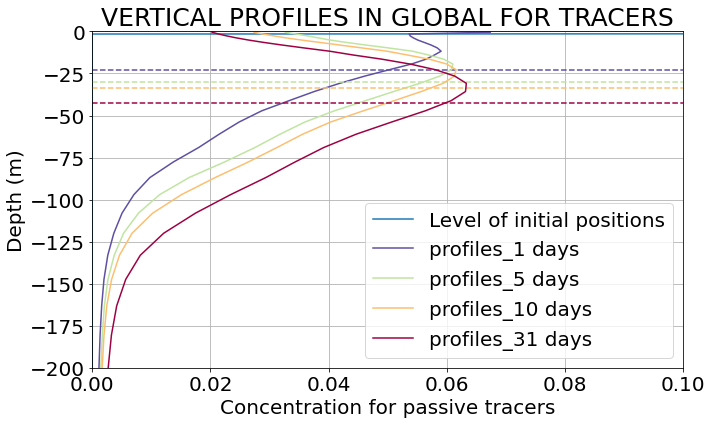

In [43]:
## Figure ##

# Create a colormap for the profiles
num_profiles = len(all_profiles_name)
cmap = plt.cm.Spectral_r
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

plt.figure(figsize=(10,6))
plt.plot(profil_ini,-ds.deptht,label=f'Level of initial positions',linewidth=1.5)

# Plot the contents of the dictionaries
for idx, (key_p, profil) in enumerate(all_profiles_name.items()):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    key_b, bary = next(iter(barycenter_name.items()))
    barycenter_name.pop(key_b)
    plt.plot(profil, -ds.deptht, label=f'{key_p} days', linewidth=1.5, color=colors[idx])
    plt.axhline(bary, linestyle='--', color=colors[idx])
    

# Customize the plot
plt.legend(loc='lower right',fontsize=20)
plt.title('VERTICAL PROFILES IN GLOBAL FOR TRACERS',fontsize=25)
plt.xlabel('Concentration for passive tracers',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,0.1)
plt.ylabel('Depth (m)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-200,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Vert_profils_E_short_time.png')

In [40]:
Time_array = np.array([183,366,731,1827])
Time_array_nemo = Time_array - 1
depth_values = ds.deptht.values

profil_ini = profil_vert_t(ds_ini["MyTrc"], 0)

# Get the data for the time scale 
all_profiles_name = {}
barycenter_name = {}

for t in Time_array_nemo:
    profil_name = f"profiles_{t+1}"
    bary_name =f"baryce_{t+1}"
    
    all_profiles_name[profil_name] = profil_vert_t(ds["MyTrc"], t)*ds_grid_renamed.e3t_1d[0]
    barycenter_name[bary_name] = barycentre_vert(-ds.deptht,all_profiles_name[profil_name])

In [36]:
ds_grid_renamed.e3t_1d[0].shape

(75,)

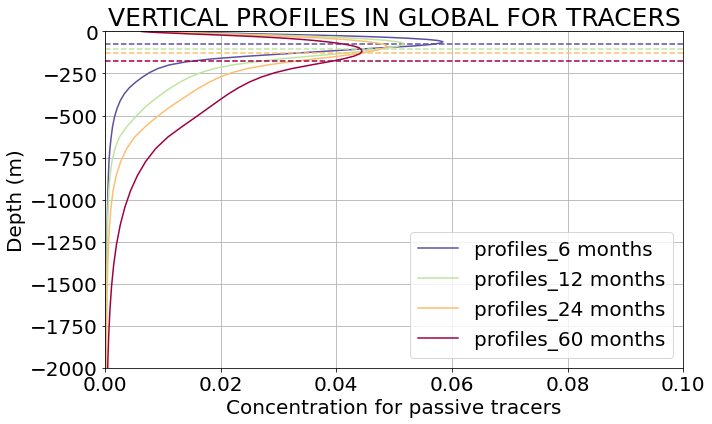

In [41]:
## Figure ##
Time_array_m = np.array([6,12,24,60,132])

# Create a colormap for the profiles
num_profiles = len(all_profiles_name)
cmap = plt.cm.Spectral_r
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

plt.figure(figsize=(10,6))
#plt.plot(profil_ini,-ds.deptht,label=f'Level of initial positions',linewidth=1.5)

# Plot the contents of the dictionaries
for idx, (key_p, profil) in enumerate(all_profiles_name.items()):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    key_b, bary = next(iter(barycenter_name.items()))
    leg = Time_array_m[idx]
    barycenter_name.pop(key_b)
    plt.plot(profil, -ds.deptht, label=f'profiles_{leg} months', linewidth=1.5, color=colors[idx])
    plt.axhline(bary, linestyle='--', color=colors[idx])
    

# Customize the plot
plt.legend(loc='lower right',fontsize=20)
plt.title('VERTICAL PROFILES IN GLOBAL FOR TRACERS',fontsize=25)
plt.xlabel('Concentration for passive tracers',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,0.1)
plt.ylabel('Depth (m)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-2000,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Vert_profils_E_long_time.png')

## Compute w* with barycenter

In [44]:
%%time
ds_profiles = xr.open_mfdataset('NEMO_Profiles/Vert_profiles_y*.nc')
ds_profiles_ini = xr.open_dataset('NEMO_Profiles/Vert_profiles_ini.nc')

depth_values = ds_grid.nav_lev.values
time_profile = ds_profiles.MyTrc.shape[0]

CPU times: user 52.8 ms, sys: 5.4 ms, total: 58.2 ms
Wall time: 58.1 ms


In [45]:
%%time
all_barycent = np.empty(time_profile)

for it in range(time_profile):
    bary = barycentre_vert(-depth_values, ds_profiles.MyTrc[it, :]*ds_grid_renamed.e3t_1d[0])
    all_barycent[it] = bary.values.item()
    
np.savez('All_baricenter.npz', all_barycent=all_barycent)

CPU times: user 42.5 s, sys: 4.03 s, total: 46.5 s
Wall time: 42.7 s


In [27]:
all_barycent[1826]

-174.95679075337344

In [25]:
All_baricenter = np.load('All_baricenter.npz')
all_barycent = All_baricenter['all_barycent'][:1827]

#all_barycent = np.arange(all_barycent).reshape(-1, 1)

time_scale1 = np.arange(0,250)
time_scale1 = time_scale1.reshape(-1, 1)
time_scale2 = np.arange(250,1827)
time_scale2 = time_scale2.reshape(-1, 1)

# Regression curves 
w_star1, barycent_predictions1 = regression(all_barycent[:250], time_scale1)
w_star2, barycent_predictions2 = regression(all_barycent[250:], time_scale2)
print(f'The w* in the first regime: {w_star1}m/s \nThe w* in the second regime:{w_star2}m/s')


The w* in the first regime: -2.6420407977919863e-06m/s 
The w* in the second regime:-5.741182721505815e-07m/s


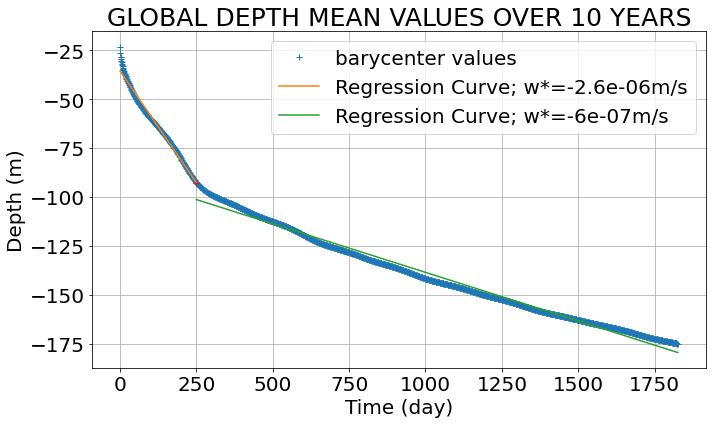

In [47]:
## Figure ##

Time_counter = np.arange(0,1827)

plt.figure(figsize = (10,6))
plt.plot(Time_counter, all_barycent, 'C0+', label='barycenter values')
#plt.plot(ds_profiles.time_counter[0],0.5,'C0+')
plt.plot(Time_counter[250], all_barycent[250], 'r+')
plt.plot(Time_counter[:250], barycent_predictions1, 'C1', label=f'Regression Curve; w*={w_star1:0.2}m/s')
plt.plot(Time_counter[250:], barycent_predictions2, 'C2', label=f'Regression Curve; w*={w_star2:0.1}m/s')

# Customize the plot
plt.legend(loc='upper right',fontsize=20)
plt.title('GLOBAL DEPTH MEAN VALUES OVER 10 YEARS',fontsize=25)
plt.xlabel('Time (day)',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
#plt.xlim(0,0.1)
plt.ylabel('Depth (m)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
#plt.ylim(-200,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Barycenter_E.png')

## Variance 

In [51]:
time_scale1 = np.arange(0,100)
time_scale1 = time_scale1.reshape(-1, 1)
time_scale2 = np.arange(100,1827)
time_scale2 = time_scale2.reshape(-1, 1)

# Variance
time = 1827
sigma2 = variance(ds_profiles.MyTrc[0:1827,:]*ds_grid_renamed.e3t_1d[0], all_barycent, ds_grid_renamed.e3t_1d[0,:], depth_values, time)

# Regression
k_star1, variance_predictions1 = regression(sigma2[:100], time_scale1)
k_star2, variance_predictions2 = regression(sigma2[100:], time_scale2)
print(f'The k* in the first regime: {k_star1:0.3} \nThe k* in the second regime:{k_star2:0.3}')

The k* in the first regime: 0.0127 
The k* in the second regime:0.00098


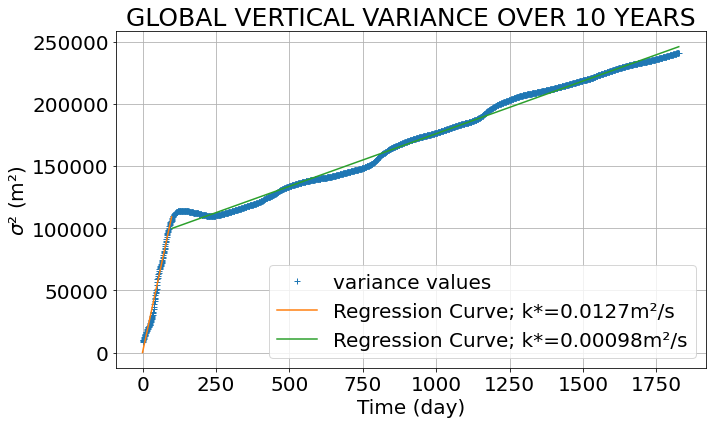

In [52]:
## Figure ##

plt.figure(figsize = (10,6))

# Plot the variance values
plt.plot(Time_counter,  sigma2, '+', label='variance values')
plt.plot(Time_counter[:100], variance_predictions1, 'C1', label=f'Regression Curve; k*={k_star1:0.3}m²/s')
plt.plot(Time_counter[100:], variance_predictions2, 'C2', label=f'Regression Curve; k*={k_star2:0.3}m²/s')

# Customize the plot
plt.legend(loc='lower right',fontsize=20)
plt.title('GLOBAL VERTICAL VARIANCE OVER 10 YEARS',fontsize=25)
plt.xlabel('Time (day)',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
#plt.xlim(0,0.1)
plt.ylabel('$\sigma²$ (m²)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
#plt.ylim(-200,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/variance_E.png')

## Zones north Atlantic 

In [15]:
## data ##
file_z = 'eORCA025.L75/eORCA025.L75-OFF-Exp1-S/1d/2000/eORCA025.L75-OFF-Exp1_*.nc'
ds_z = xr.open_mfdataset(dir+file_z)
ds_z

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Time array
    # For the plot 
Time_array = np.array([1,5,10,31,183,365])
Time_array_nemo = Time_array - 1
    # For computing 
Time_zones = ds_z.time_counter.shape[0]
time_scale = np.arange(Time_zones).reshape(-1, 1)


<ipython-input-16-5af848d736a0>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  fig = m.pcolormesh(x, y, cumulative_data[time_step,:,:].values, cmap=plt.cm.Spectral_r)


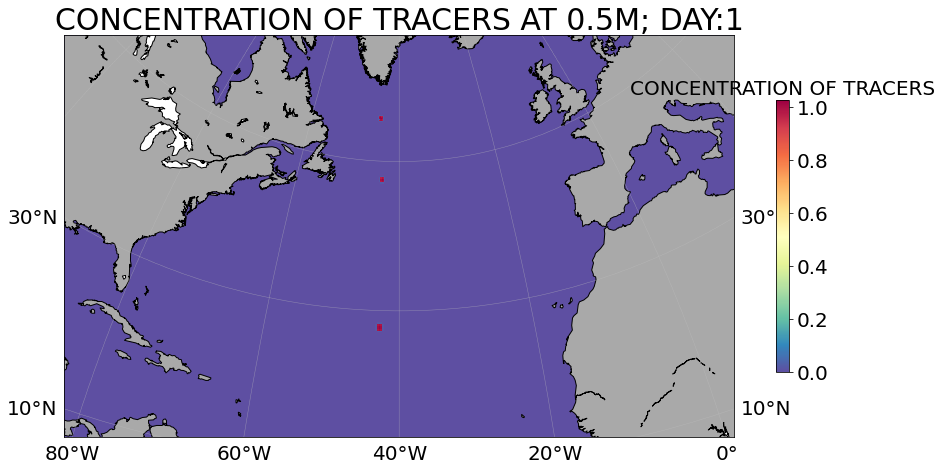

In [16]:
time_step = 0
i_depth = 0

cumulative_data = ds_z["MyTrc"][:, :, :, :]*ds_grid_renamed.e3t_1d[0]
cumulative_data = cumulative_data.sum(dim='deptht', skipna=True)

plt.figure(figsize=(15,10))
m = Basemap(width=10000000,height=6000000, resolution='l',projection='stere',
        lat_0=40.,lon_0=-40.)
m.fillcontinents(color='darkgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 91., 20.), labels=[1, 1, 0, 0], dashes=[1, 1], linewidth=0.5, color='0.75', fontsize=20)
m.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1], dashes=[1, 1], linewidth=0.5, color='0.75', fontsize=20)

x, y = m(ds_z["nav_lon"].values, ds_z["nav_lat"].values)
#fig = m.pcolormesh(x, y, ds_z["MyTrc"][time_step,i_depth,:,:].values, cmap=plt.cm.Spectral_r)
fig = m.pcolormesh(x, y, cumulative_data[time_step,:,:].values, cmap=plt.cm.Spectral_r)
    
#cbar = plt.colorbar(fig,orientation='horizontal',shrink=0.5)
cbar = plt.colorbar(fig,shrink=0.5)
cbar.ax.tick_params(labelsize=20)
#cbar.ax.set_title('CONCENTRATION OF TRACERS', fontsize=20)
#map.set_clim(vmin=0, vmax=1)
plt.title(f'CONCENTRATION OF TRACERS AT {ds_z.deptht.values[i_depth]:0.1}M; DAY:{time_step+1}',fontsize=30)
plt.savefig(f'Results/Zones_NEMO_day{time_step+1}.png')

### Profiles + Barycenter + Variance

In [5]:
# Profiles computed 
#zone_GSP = ds_z["MyTrc"][:, :, 929:972, 957:1000]
#zone_NAC = ds_z["MyTrc"][:, :, 879:922, 957:1000]
#zone_GST = ds_z["MyTrc"][:, :, 779:822, 957:1000]

zone_GSP = ds_z["MyTrc"][:, :, 949:952, 977:979]
zone_NAC = ds_z["MyTrc"][:, :, 899:902, 977:979]
zone_GST = ds_z["MyTrc"][:, :, 799:802, 977:979]

GSP_profiles = profiles_vert(zone_GSP)*ds_grid_renamed.e3t_1d[0]
NAC_profiles = profiles_vert(zone_NAC)*ds_grid_renamed.e3t_1d[0]
GST_profiles = profiles_vert(zone_GST)*ds_grid_renamed.e3t_1d[0]

In [6]:
%%time
# Barycenters computed 
all_barycent_GSP = np.empty(Time_zones)
all_barycent_NAC = np.empty(Time_zones)
all_barycent_GST = np.empty(Time_zones)

for it in range(Time_zones):
    all_barycent_GSP[it] = barycentre_vert(-depth_values, GSP_profiles[it, :])
    all_barycent_NAC[it] = barycentre_vert(-depth_values, NAC_profiles[it, :])
    all_barycent_GST[it] = barycentre_vert(-depth_values, GST_profiles[it, :])

np.savez('Zones_baricenter.npz', all_barycent_GSP=all_barycent_GSP, all_barycent_NAC=all_barycent_NAC, all_barycent_GST=all_barycent_GST)

CPU times: user 35min 56s, sys: 1min 10s, total: 37min 6s
Wall time: 37min 32s


In [7]:
# Computing of barycenter take time; therefore there are salved, and can be only loaded here 
Zones_baricenter = np.load('Zones_baricenter.npz')
all_barycent_GSP = Zones_baricenter['all_barycent_GSP']
all_barycent_NAC = Zones_baricenter['all_barycent_NAC']
all_barycent_GST = Zones_baricenter['all_barycent_GST']

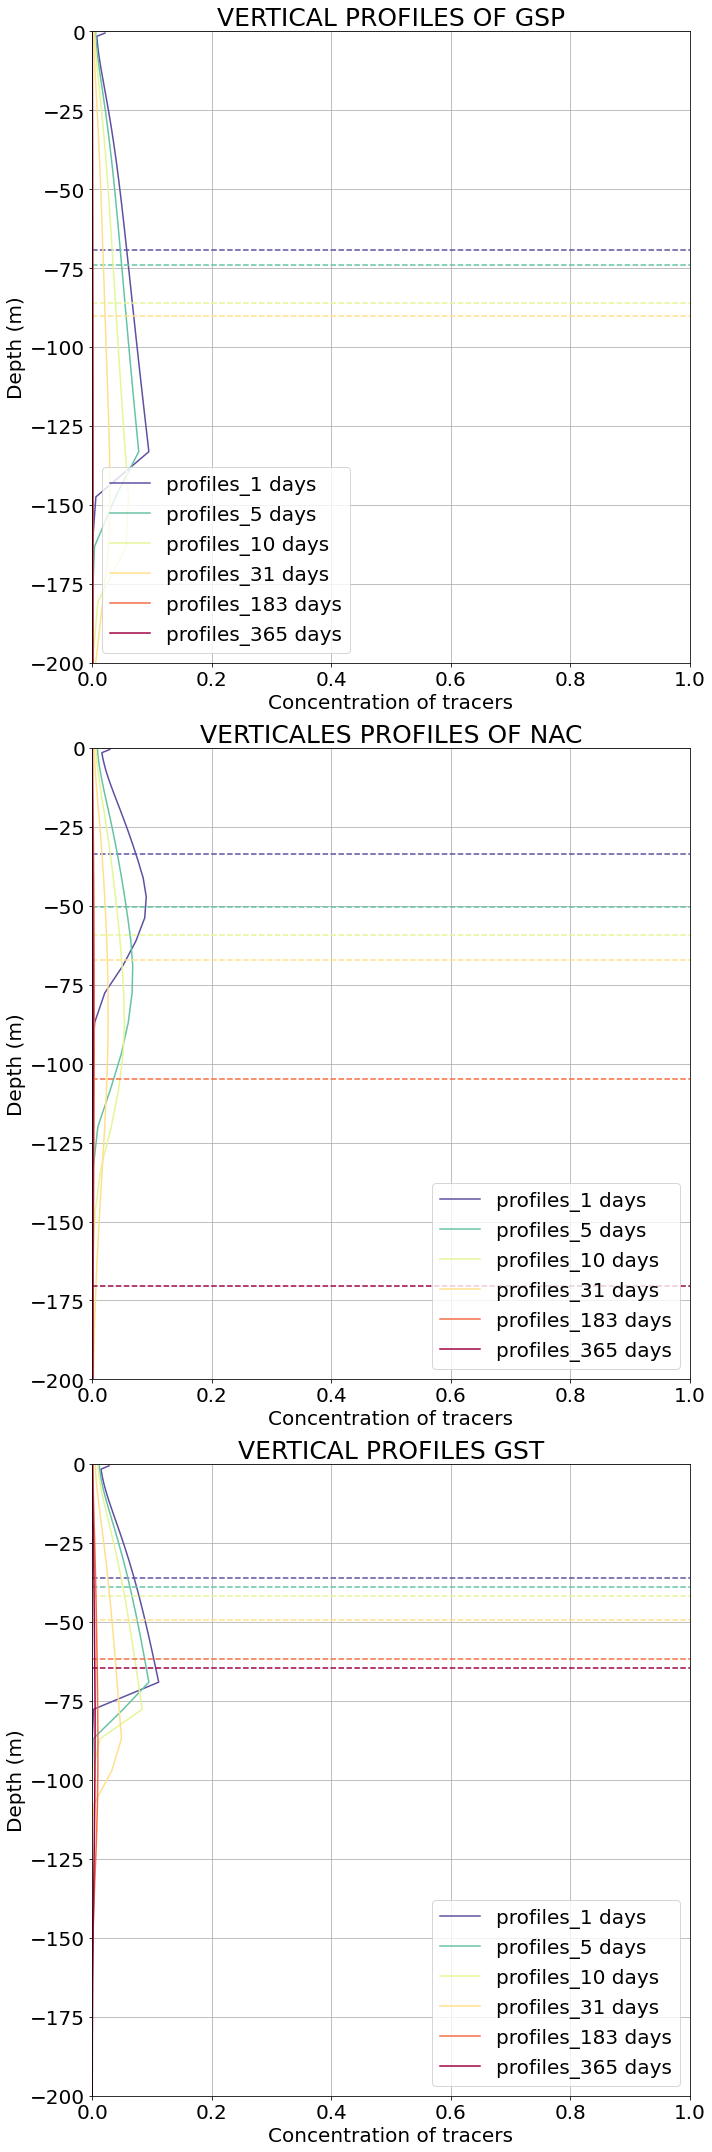

In [11]:
## Figure for the profiles ##

cmap = plt.cm.Spectral_r
num_profiles = len(Time_array)
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

# Create separate plots for GSP, GS, and GST
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

# Plot data for GSP
for idx in range(num_profiles):
    key_p = Time_array[idx]
    time_index = Time_array_nemo[idx]
    ax1.plot(GSP_profiles[time_index,:], -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    ax1.axhline(all_barycent_GSP[time_index], linestyle='--', color=colors[idx])
ax1.set_ylabel('Depth (m)', fontsize=20)
ax1.set_xlabel('Concentration of tracers', fontsize=20)
ax1.set_xlim(0,1)
ax1.set_ylim(-200,0)
ax1.grid()
ax1.legend(loc='lower left', fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('VERTICAL PROFILES OF GSP', fontsize=25)

# Plot data for GS
for idx in range(num_profiles):
    key_p = Time_array[idx]
    time_index = Time_array_nemo[idx]
    ax2.plot(NAC_profiles[time_index,:], -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    ax2.axhline(all_barycent_NAC[time_index], linestyle='--', color=colors[idx])
ax2.set_ylabel('Depth (m)', fontsize=20)
ax2.set_xlabel('Concentration of tracers', fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(-200,0)
ax2.grid()
ax2.legend(loc='lower right',fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('VERTICALES PROFILES OF NAC', fontsize=25)

# Plot data for GST
for idx in range(num_profiles):
    key_p = Time_array[idx]
    time_index = Time_array_nemo[idx]
    ax3.plot(GST_profiles[time_index,:], -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    ax3.axhline(all_barycent_GST[time_index], linestyle='--', color=colors[idx])
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.set_xlabel('Concentration of tracers', fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(-200,0)
ax3.grid()
ax3.legend(loc='lower right',fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('VERTICAL PROFILES GST', fontsize=25)

# Customize the overall plot
#fig.suptitle('Vertical Profiles of Tracer Distribution', fontsize=30)
plt.tight_layout()  # Add space for the suptitle
plt.savefig('Results/Zones_Vert_profiles_E.png')

For the first part:  
 The w_GSP: -7.3e-05m/day 
 The w_NAC: -2.2e-05m/day 
 The w_GST: -2.3e-06m/day
For the second part: 
 The w_GSP: -1.1e-06m/day 
 The w_NAC: -3.7e-06m/day 
 The w_GST: -1.7e-07m/day


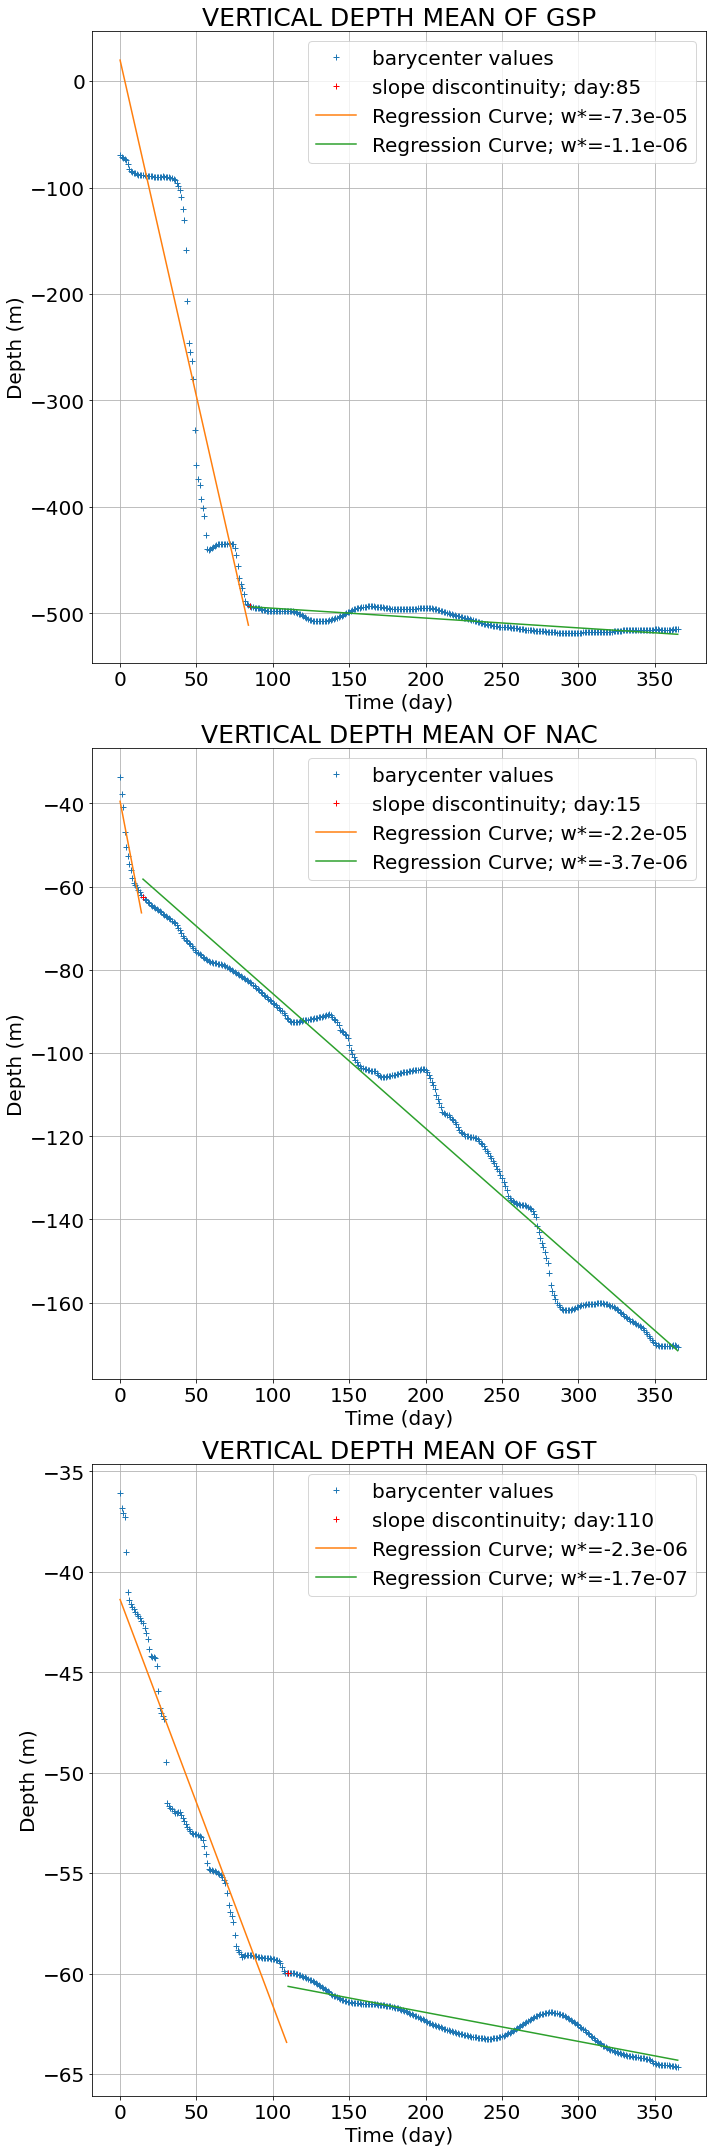

In [12]:
## Regression function for w*

barycenter_GSP = all_barycent_GSP.reshape(-1, 1)
barycenter_NAC = all_barycent_NAC.reshape(-1, 1)
barycenter_GST = all_barycent_GST.reshape(-1, 1)


# First regime 
w_GSP1, bary_pred_GSP1 = regression(barycenter_GSP[:85], time_scale[:85])
w_NAC1, bary_pred_NAC1 = regression(barycenter_NAC[:15], time_scale[:15])
w_GST1, bary_pred_GST1 = regression(barycenter_GST[:110], time_scale[:110])

w_GSP2, bary_pred_GSP2 = regression(barycenter_GSP[85:], time_scale[85:])
w_NAC2, bary_pred_NAC2 = regression(barycenter_NAC[15:], time_scale[15:])
w_GST2, bary_pred_GST2 = regression(barycenter_GST[110:], time_scale[110:])

print(f'For the first part:  \n The w_GSP: {w_GSP1[0]:0.2}m/day \n The w_NAC: {w_NAC1[0]:0.2}m/day \n The w_GST: {w_GST1[0]:0.2}m/day')
print(f'For the second part: \n The w_GSP: {w_GSP2[0]:0.2}m/day \n The w_NAC: {w_NAC2[0]:0.2}m/day \n The w_GST: {w_GST2[0]:0.2}m/day')

## figure for the w* ##

# Create separate plots for GSP, GS, and GST
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

# Plot data for GSP
ax1.plot(time_scale, barycenter_GSP, 'C0+', label='barycenter values')
ax1.plot(time_scale[85], barycenter_GSP[85], 'r+', label='slope discontinuity; day:85')
ax1.plot(time_scale[:85], bary_pred_GSP1, 'C1', label=f'Regression Curve; w*={w_GSP1[0]:0.2}')
ax1.plot(time_scale[85:], bary_pred_GSP2, 'C2', label=f'Regression Curve; w*={w_GSP2[0]:0.2}')
ax1.set_ylabel('Depth (m)', fontsize=20)
ax1.set_xlabel('Time (day)', fontsize=20)
ax1.grid()
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('VERTICAL DEPTH MEAN OF GSP', fontsize=25)

# Plot data for GS
ax2.plot(time_scale, barycenter_NAC, 'C0+', label='barycenter values')
ax2.plot(time_scale[15], barycenter_NAC[15], 'r+', label='slope discontinuity; day:15')
ax2.plot(time_scale[:15], bary_pred_NAC1, 'C1', label=f'Regression Curve; w*={w_NAC1[0]:0.2}')
ax2.plot(time_scale[15:], bary_pred_NAC2, 'C2', label=f'Regression Curve; w*={w_NAC2[0]:0.2}')
ax2.set_ylabel('Depth (m)', fontsize=20)
ax2.set_xlabel('Time (day)', fontsize=20)
ax2.grid()
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('VERTICAL DEPTH MEAN OF NAC', fontsize=25)

# Plot data for GST
ax3.plot(time_scale, barycenter_GST, 'C0+', label='barycenter values')
ax3.plot(time_scale[110], barycenter_GST[110], 'r+', label='slope discontinuity; day:110')
ax3.plot(time_scale[:110], bary_pred_GST1, 'C1', label=f'Regression Curve; w*={w_GST1[0]:0.2}')
ax3.plot(time_scale[110:], bary_pred_GST2, 'C2', label=f'Regression Curve; w*={w_GST2[0]:0.2}')
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.set_xlabel('Time (day)', fontsize=20)
ax3.grid()
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('VERTICAL DEPTH MEAN OF GST', fontsize=25)

# Customize the overall plot
#fig.suptitle('Vertical Profiles of Tracer Distribution', fontsize=30)
plt.tight_layout()  # Add space for the suptitle
plt.savefig('Results/Zones_w_E.png')

In [13]:
%%time
# Variance
sigma2_GSP = variance(GSP_profiles, barycenter_GSP, ds_grid_renamed.e3t_1d[0,:], depth_values, Time_zones)
sigma2_NAC = variance(NAC_profiles, barycenter_NAC, ds_grid_renamed.e3t_1d[0,:], depth_values, Time_zones)
sigma2_GST = variance(GST_profiles, barycenter_GST, ds_grid_renamed.e3t_1d[0,:], depth_values, Time_zones)

np.savez('Zones_sigma2.npz', sigma2_GSP=sigma2_GSP, sigma2_NAC=sigma2_NAC, sigma2_GST=sigma2_GST)

CPU times: user 33min 14s, sys: 1min 4s, total: 34min 19s
Wall time: 34min 36s


In [14]:
barycenter_GSP = all_barycent_GSP.reshape(-1, 1)
barycenter_NAC = all_barycent_NAC.reshape(-1, 1)
barycenter_GST = all_barycent_GST.reshape(-1, 1)

In [15]:
Zones_sigma2 = np.load("Zones_sigma2.npz")
sigma2_GSP = Zones_sigma2['sigma2_GSP']
sigma2_NAC = Zones_sigma2['sigma2_NAC']
sigma2_GST = Zones_sigma2['sigma2_GST']

In [18]:
# Regression
k_GSP1, var_pred_GSP1 = regression(sigma2_GSP[:45], time_scale[:45])
k_GSP2, var_pred_GSP2 = regression(sigma2_GSP[45:], time_scale[45:])

k_NAC1, var_pred_NAC1 = regression(sigma2_NAC[:100], time_scale[:100])
k_NAC2, var_pred_NAC2 = regression(sigma2_NAC[100:], time_scale[100:])

k_GST1, var_pred_GST1 = regression(sigma2_GST[:45], time_scale[:45])
k_GST2, var_pred_GST2 = regression(sigma2_GST[45:], time_scale[45:])

print(f'For the first part:  \n The k_GSP:{k_GSP1:0.2}m²/s \n The k_NAC:{k_NAC:0.2}m²/s \n The k_GST:{k_GST1:0.2}m²/s')
print(f'For the second part: \n The k_GSP:{k_GSP2:0.2}m²/s \n The k_NAC:{k_NAC:0.2}m²/s \n The k_GST:{k_GST2:0.2}m²/s')


For the first part:  
 The k_GSP:0.0013m²/s 
 The k_NAC:0.0055m²/s 
 The k_GST:0.00013m²/s
For the second part: 
 The k_GSP:0.0037m²/s 
 The k_NAC:0.0055m²/s 
 The k_GST:3.5e-05m²/s


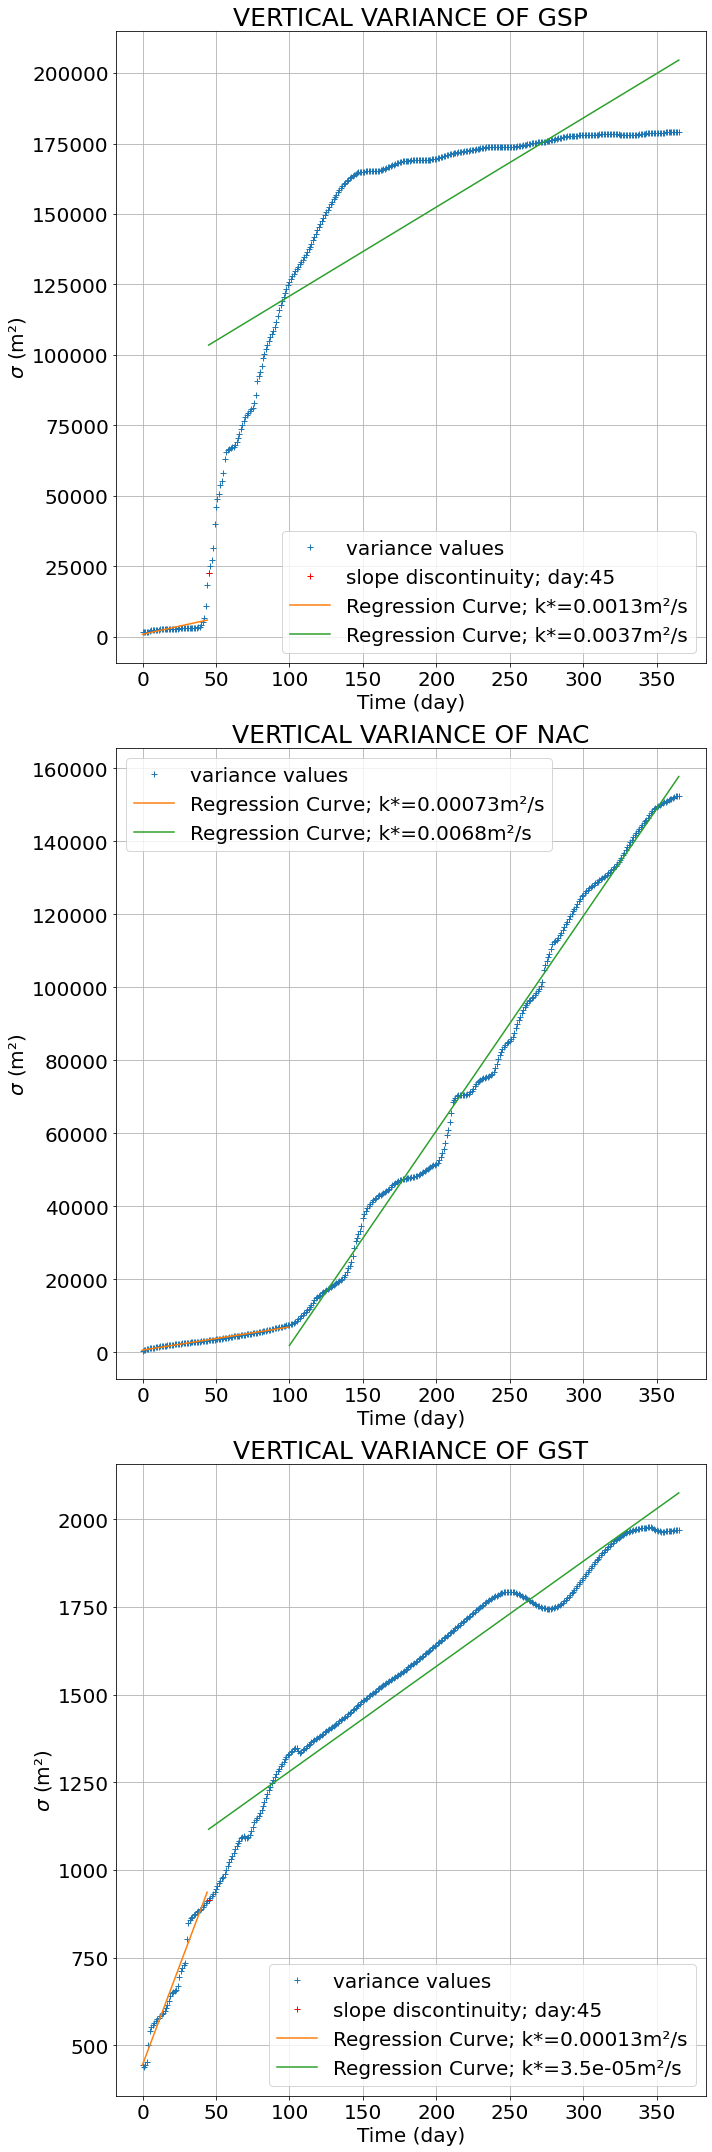

In [19]:
## Figure ##
# Create separate plots for GSP, GS, and GST
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

# Plot data for GSP
ax1.plot(time_scale, sigma2_GSP, 'C0+', label='variance values')
ax1.plot(time_scale[45], sigma2_GSP[45], 'r+', label='slope discontinuity; day:45')
ax1.plot(time_scale[:45], var_pred_GSP1, 'C1', label=f'Regression Curve; k*={k_GSP1:0.2}m²/s')
ax1.plot(time_scale[45:], var_pred_GSP2, 'C2', label=f'Regression Curve; k*={k_GSP2:0.2}m²/s')
ax1.set_ylabel('$\sigma$ (m²)', fontsize=20)
ax1.set_xlabel('Time (day)', fontsize=20)
ax1.grid()
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('VERTICAL VARIANCE OF GSP', fontsize=25)

# Plot data for GS
ax2.plot(time_scale, sigma2_NAC, 'C0+', label='variance values')
#ax2.plot(time_scale[45], sigma2_NAC[45], 'r+', label='slope discontinuity; day:45')
ax2.plot(time_scale[:100], var_pred_NAC1, 'C1', label=f'Regression Curve; k*={k_NAC1:0.2}m²/s')
ax2.plot(time_scale[100:], var_pred_NAC2, 'C2', label=f'Regression Curve; k*={k_NAC2:0.2}m²/s')
ax2.set_ylabel('$\sigma$ (m²)', fontsize=20)
ax2.set_xlabel('Time (day)', fontsize=20)
ax2.grid()
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('VERTICAL VARIANCE OF NAC', fontsize=25)

# Plot data for GST
ax3.plot(time_scale, sigma2_GST, 'C0+', label='variance values')
ax3.plot(time_scale[45], sigma2_GST[45], 'r+', label='slope discontinuity; day:45')
ax3.plot(time_scale[:45], var_pred_GST1, 'C1', label=f'Regression Curve; k*={k_GST1:0.2}m²/s')
ax3.plot(time_scale[45:], var_pred_GST2, 'C2', label=f'Regression Curve; k*={k_GST2:0.2}m²/s')
ax3.set_ylabel('$\sigma$ (m²)', fontsize=20)
ax3.set_xlabel('Time (day)', fontsize=20)
ax3.grid()
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('VERTICAL VARIANCE OF GST', fontsize=25)

# Customize the overall plot
#fig.suptitle('Vertial variance of Tracer', fontsize=30)
plt.tight_layout()  # Add space for the suptitle
plt.savefig('Results/Zones_k_E.png')

# Results from the ARIANE simulation - Lagrangian

In [7]:
## Read Data of the 3 first months ##
file_L = 'ARIANE/Exp_ORCA25/ariane_trajectories_qualitative.nc'
ds_L = xr.open_dataset(dir+file_L)

# Data for 10 years with large dt (30 days)
file_lL = 'ARIANE/Exp_ORCA25_10y/ariane_initial.nc'
ds_lL = xr.open_dataset(dir+file_lL)

# Parameters of the Lagrangian simulation 
nop = ds_L.traj_iU.shape[1] # total nomber of particle 
#nt = ds_L.traj_iU.shape[0] # total output
#ntl = ds_lL.traj_iU.shape[0] # total output

# Calculate the dimensions from the data
nz, ny, nx = ds_grid.tmask.shape[1:]
depth_values = ds_grid.nav_lev
dv = ds_grid.e3t_0[0] * ds_grid.e1t[0] * ds_grid.e2t[0]

# Time arrays
Time_array = np.array([1,5,10,31])
Time = ds_L["traj_time"].shape[0]

Time_array_l = np.array([6,12,24,60])
Time_l = ds_lL["traj_time"].shape[0]

time_scale = np.arange(Time).reshape(-1, 1)
time_scale_l = np.arange(120,1800,30).reshape(-1, 1)
Time_scale = np.concatenate((time_scale, time_scale_l))

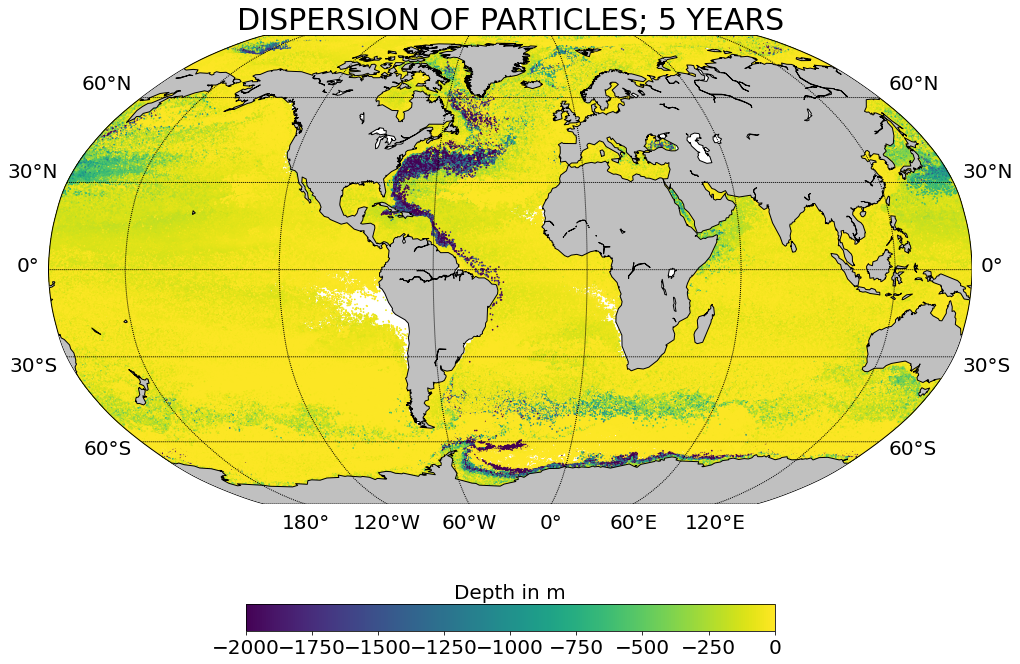

In [13]:
time_step = 60

## Figure ##

plt.figure(figsize=(15,10))
m = Basemap(projection='robin',lon_0=-30,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.),labels=[1,1,0,0],fontsize=20)
m.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,0,1],fontsize=20)

x, y = m(ds_lL.traj_lon[time_step,:].values, ds_lL.traj_lat[time_step,:].values)
map = m.scatter(x, y, s=0.5, c = ds_lL.traj_depth[time_step,:].values)
    
cbar = plt.colorbar(map, orientation='horizontal',shrink=0.5)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title("Depth in m",fontsize=20)
map.set_clim(vmin=-2000, vmax=0)
plt.title(f"DISPERSION OF PARTICLES; 5 YEARS",fontsize=30)
plt.tight_layout()
plt.savefig(f"Results/Glob_map_A_it{time_step}.png")

In [2]:
#%%time
# Preallocate arrays
#n_part = np.zeros((nz, ny, nx), dtype=int)
#mt = 0

# Use broadcasting for calculations
#valid_indices = ds_L.traj_iU[mt,:] > 0  # filter NaN

#ix = np.clip((ds_L.traj_iU[mt, valid_indices] + 1).astype(int), 0, nx - 1)
#jy = np.clip((ds_L.traj_jV[mt, valid_indices] + 1).astype(int), 0, ny - 1)
#kz = np.clip((-ds_L.traj_kW[mt, valid_indices]).astype(int), 0, nz - 1)

# Increment n_part using numpy advanced indexing
#n_part[kz, jy, ix] += 1

In [1]:
#time_step = 0

## Figure ##

#plt.figure(figsize=(15,10))
#m = Basemap(projection='robin',lon_0=-30,resolution='c')
#m.drawcoastlines()
#m.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
# draw parallels and meridians.
#m.drawparallels(np.arange(-90.,120.,30.),labels=[1,1,0,0],fontsize=20)
#m.drawmeridians(np.arange(0.,360.,60.),labels=[0,0,0,1],fontsize=20)

#x, y = m(ds_L.traj_lon[time_step,:].values, ds_L.traj_lat[time_step,:].values)
#map = m.pcolormesh()
    
#cbar = plt.colorbar(map, orientation='horizontal',shrink=0.5)
#cbar.ax.tick_params(labelsize=20)
#cbar.ax.set_title("Depth in m",fontsize=20)
#map.set_clim(vmin=-2, vmax=0)
#plt.title(f"DISPERSION OF PARTICLES; DAY:{time_step}",fontsize=30)
#plt.tight_layout()
#plt.savefig(f"Results/Glob_map_A_it{time_step}.png")

## Vertical profiles

In [5]:
%%time
# Preallocate arrays
n_part = np.zeros((nz, ny, nx), dtype=int)
profiles = np.zeros((Time,nz))
barycenter = np.zeros((Time))
var_profiles = np.zeros((Time))

for mt in range(Time):
    # Use broadcasting for calculations
    valid_indices = ds_L.traj_iU[mt] > 0  # filter NaN

    ix = np.clip((ds_L.traj_iU[mt, valid_indices] + 1).astype(int), 0, nx - 1)
    jy = np.clip((ds_L.traj_jV[mt, valid_indices] + 1).astype(int), 0, ny - 1)
    kz = np.clip((-ds_L.traj_kW[mt, valid_indices]).astype(int), 0, nz - 1)

    # Increment n_part using numpy advanced indexing
    n_part[kz, jy, ix] += 1

    # Calculate c_part
    c_part = n_part / dv

    # Calculate profil directly in a single step
    profiles[mt,:] = np.mean(c_part*1.4e7, axis=(1, 2))*ds_grid.e3t_1d[0]
    barycenter[mt] = barycentre_vert_L(-depth_values, profiles[mt,:])
    
output_filename = "global_data_L.npz"
np.savez(output_filename, profiles=profiles, barycenter=barycenter, var_profiles=var_profiles)

KeyboardInterrupt: 

In [11]:
data_L = np.load("global_data_L.npz")
profiles = data_L['profiles']
barycenter = data_L['barycenter']

In [13]:
ds_L

<xarray.Dataset>
Dimensions:       (ntraj: 19512484, nb_output: 92)
Dimensions without coordinates: ntraj, nb_output
Data variables: (12/19)
    init_x        (ntraj) float64 ...
    init_y        (ntraj) float64 ...
    init_z        (ntraj) float64 ...
    init_t        (ntraj) float64 ...
    init_age      (ntraj) timedelta64[ns] ...
    init_transp   (ntraj) float64 ...
    ...            ...
    traj_lat      (nb_output, ntraj) float64 ...
    traj_depth    (nb_output, ntraj) float64 ...
    traj_time     (nb_output, ntraj) float64 ...
    traj_iU       (nb_output, ntraj) float64 ...
    traj_jV       (nb_output, ntraj) float64 ...
    traj_kW       (nb_output, ntraj) float64 ...
Attributes: (12/83)
    key_roms:                .FALSE.
    key_mars:                .FALSE.
    key_symphonie:           .FALSE.
    key_B2C_grid:            .FALSE.
    key_sequential:          .TRUE.
    key_alltracers:          .FALSE.
    ...                      ...
    indn_ve:                 6
    maxsize_ve:              3
    c_suffix_ve:             .nc
    nc_var_ve:               vovecrtz
    nc_var_eivw:             NONE
    nc_att_mask_ve:          missing_value

In [15]:
bary = ds_L.traj_depth.mean(dim=['ntraj'], skipna=True)

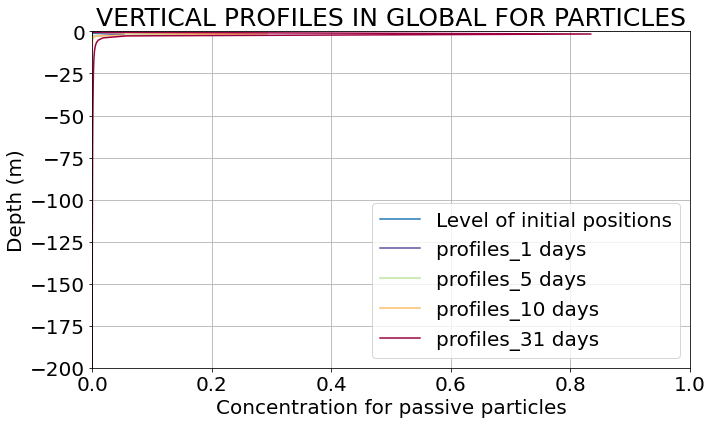

In [12]:
## Figure ##
cmap = plt.cm.Spectral_r
num_profiles = len(Time_array)
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

plt.figure(figsize=(10,6))
plt.plot(profiles[0,:],-ds_grid.e3t_1d[0,:],label=f'Level of initial positions',linewidth=1.5)

for idx in range(num_profiles):
    key_p = Time_array[idx]
    plt.plot(profiles[key_p,:], -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    #plt.axhline(bary, linestyle='--', color=colors[idx])

plt.legend(loc='lower right',fontsize=20)
plt.title('VERTICAL PROFILES IN GLOBAL FOR PARTICLES',fontsize=25)
plt.xlabel('Concentration for passive particles',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,1)
plt.ylabel('Depth (m)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-200,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Vert_profils_L_short_time.png')

In [36]:
%%time
# Preallocate arrays
n_part = np.zeros((nz, ny, nx), dtype=int)
profiles_l = np.zeros((Time_l,nz))
barycenter_l = np.zeros((Time_l))
var_profiles_l = np.zeros((Time_l))

for mt in range(Time_l):
    # Use broadcasting for calculations
    valid_indices = ds_lL.traj_iU[mt] > 0  # filter NaN

    ix = np.clip((ds_lL.traj_iU[mt, valid_indices] + 1).astype(int), 0, nx - 1)
    jy = np.clip((ds_lL.traj_jV[mt, valid_indices] + 1).astype(int), 0, ny - 1)
    kz = np.clip((-ds_lL.traj_kW[mt, valid_indices]).astype(int), 0, nz - 1)

    # Increment n_part using numpy advanced indexing
    n_part[kz, jy, ix] += 1

    # Calculate c_part
    c_part = n_part / dv

    # Calculate profil directly in a single step
    profiles_l[mt,:] = np.mean(c_part*1.4e7, axis=(1, 2))*ds_grid.e3t_1d[0]
    barycenter_l[mt] = barycentre_vert_L(-depth_values, profiles_l[mt,:])
    
output_filename = "global_data_lL.npz"
np.savez(output_filename, profiles_l=profiles_l, barycenter_l=barycenter_l)

CPU times: user 6min 54s, sys: 2min 31s, total: 9min 25s
Wall time: 9min 51s


In [39]:
data_lL = np.load("global_data_lL.npz")
profiles_l = data_lL['profiles_l']
barycenter_l = data_lL['barycenter_l']

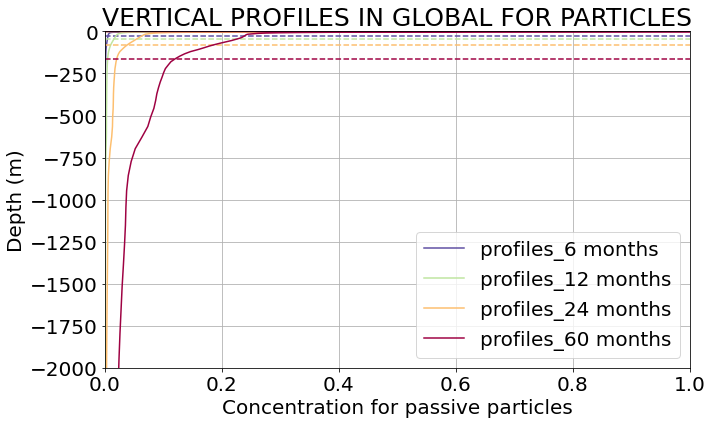

In [42]:
## Figure ##
cmap = plt.cm.Spectral_r
num_profiles = len(Time_array_l)
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

plt.figure(figsize=(10,6))

for idx in range(num_profiles):
    key_p = Time_array_l[idx]
    plt.plot(profiles_l[key_p,:], -depth_values, label=f'profiles_{key_p} months', linewidth=1.5, color=colors[idx])
    plt.axhline(barycenter_l[key_p], linestyle='--', color=colors[idx])
    #plt.axhline(bary[key_p], linestyle='--', color=colors[idx])

plt.legend(loc='lower right',fontsize=20)
plt.title('VERTICAL PROFILES IN GLOBAL FOR PARTICLES',fontsize=25)
plt.xlabel('Concentration for passive particles',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,1)
plt.ylabel('Depth (m)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-2000,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Vert_profils_L_long_time.png')

In [8]:
test = barycentre_vert_L(-depth_values, profiles_l[60,:])

NameError: name 'barycentre_vert_L' is not defined

## Compute w with barycenter + Variance

In [31]:
barycenter_l[60]

-161.8354501198611

The w: [-1.04058716e-07]m/s


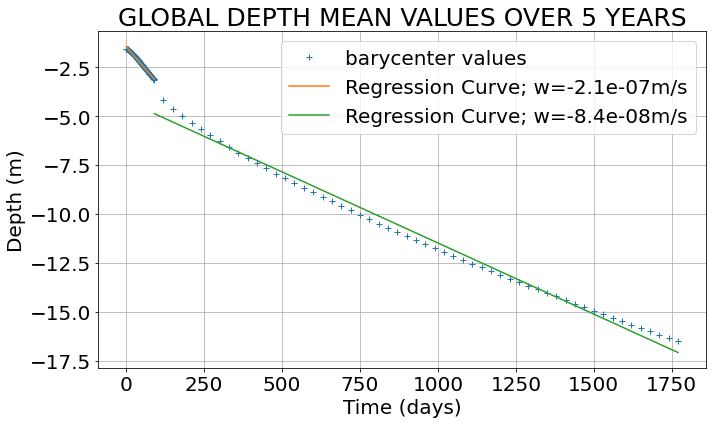

In [23]:
## Regression function for w*

Time_scale = np.concatenate((time_scale, time_scale_l))

barycenter = barycenter.reshape(-1, 1)
barycenter_l = barycenter_l.reshape(-1, 1)
barycent = np.concatenate((barycenter, barycenter_l[5:]))

w1, bary_pred1 = regression(barycent[:91], Time_scale[:91])
w2, bary_pred2 = regression(barycent[91:], Time_scale[91:])
print(f'The w: {w}m/s')


## Figure ##

plt.figure(figsize = (10,6))
plt.plot(Time_scale, barycent, 'C0+', label='barycenter values')
plt.plot(Time_scale[:91], bary_pred1, 'C1', label=f'Regression Curve; w={w1[0]:0.2}m/s')
plt.plot(Time_scale[91:], bary_pred2, 'C2', label=f'Regression Curve; w={w2[0]:0.2}m/s')


# Customize the plot
plt.legend(loc='upper right',fontsize=20)
plt.title('GLOBAL DEPTH MEAN VALUES OVER 5 YEARS',fontsize=25)
plt.xlabel('Time (days)',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
#plt.xlim(0,0.1)
plt.ylabel('Depth (m)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
#plt.ylim(-200,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/Barycenter_L.png')

In [24]:
# Variance 

Time_scale = np.concatenate((time_scale, time_scale_l))

var = ds_L.traj_depth.var(dim=['ntraj'], skipna=True)
varl = ds_lL.traj_depth.var(dim=['ntraj'], skipna=True)

sigma2_L = np.concatenate((var, varl[5:]))


# Regression curves for the variance 
k1, var_pred1 = regression(sigma2_L[:91], Time_scale[:91])
k2, var_pred2 = regression(sigma2_L[91:], Time_scale[91:])

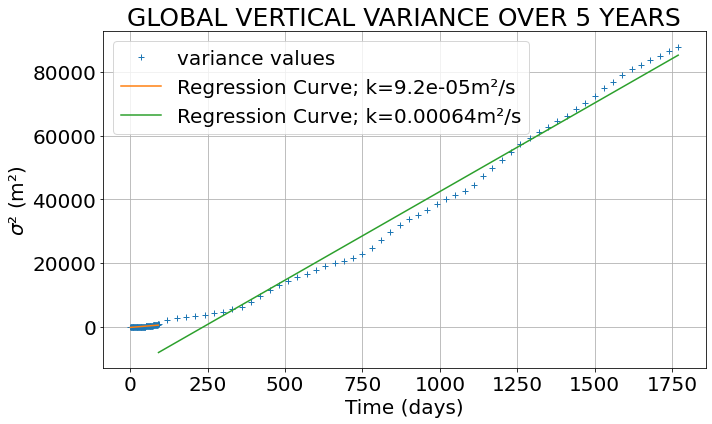

In [29]:
## Figure ##

plt.figure(figsize = (10,6))
plt.plot(Time_scale, sigma2_L, 'C0+', label='variance values')
plt.plot(Time_scale[:91], var_pred1, 'C1', label=f'Regression Curve; k={k1:0.2}m²/s')
plt.plot(Time_scale[91:], var_pred2, 'C2', label=f'Regression Curve; k={k2:0.2}m²/s')

# Customize the plot
plt.legend(loc='upper left',fontsize=20)
plt.title('GLOBAL VERTICAL VARIANCE OVER 5 YEARS',fontsize=25)
plt.xlabel('Time (days)',fontsize=20)
plt.tick_params(axis='x', labelsize=20)
#plt.xlim(0,0.1)
plt.ylabel('$\sigma²$ (m²)',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
#plt.ylim(-200,0)
plt.grid()
plt.tight_layout()
plt.savefig('Results/variance_L.png')

## Zones north Atlantic 

In [ ]:
## data ##
file_zL = 'ARIANE/Exp_ORCA25_zones/ariane_trajectories_qualitative.nc'
ds_zL = xr.open_dataset(dir+file_zL)

# Time arrays
Time = ds_zL["traj_time"].shape[0]
Time_array = np.array([1,5,10,31,183,365])
    # For computing 
Time_zones = ds_zL.traj_time.shape[0]
time_scale = np.arange(Time_zones).reshape(-1, 1)

# Calculate the dimensions from the data
nz, ny, nx = ds_grid.tmask.shape[1:]
depth_values = ds_grid.nav_lev
dv = ds_grid.e3t_0[0] * ds_grid.e1t[0] * ds_grid.e2t[0]

# Define subdomains
zone_1 = slice(0, 1356)
zone_2 = slice(1356, 3111)
zone_3 = slice(3111, 5986)

zones = [zone_1, zone_2, zone_3]

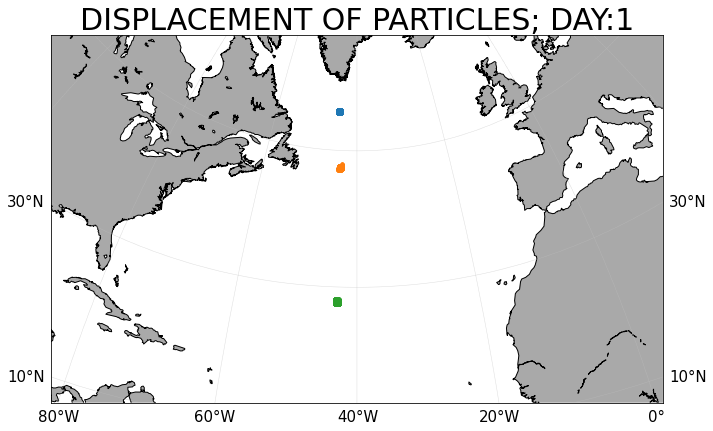

In [31]:
time_step = 1

plt.figure(figsize=(10,10))
m = Basemap(width=10000000,height=6000000, resolution='l',projection='stere',
        lat_0=40.,lon_0=-40.)
m.fillcontinents(color='darkgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 91., 20.), labels=[1, 1, 0, 0], dashes=[1, 1], linewidth=0.5, color='0.75', fontsize=15)
m.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1], dashes=[1, 1], linewidth=0.5, color='0.75', fontsize=15)

x1, y1 = m(ds_zL.traj_lon[time_step,zone_1].values, ds_zL.traj_lat[time_step,zone_1].values)
x2, y2 = m(ds_zL.traj_lon[time_step,zone_2].values, ds_zL.traj_lat[time_step,zone_2].values)
x3, y3 = m(ds_zL.traj_lon[time_step,zone_3].values, ds_zL.traj_lat[time_step,zone_3].values)

map1 = m.plot(x1, y1, '.')
map2 = m.plot(x2, y2, '.')
map3 = m.plot(x3, y3, '.')
#map = m.plot(x, y, s=0.5, c = ds_zL.traj_depth[time_step,:].values)
"""    
cbar = plt.colorbar(map, orientation='horizontal', shrink=0.75)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title("Depth in m",fontsize=15)
map.set_clim(vmin=-5, vmax=0)
"""
plt.title(f"DISPLACEMENT OF PARTICLES; DAY:{time_step}",fontsize=30)
plt.tight_layout()
plt.savefig(f"Results/Zones_Ariane_day{time_step}.png")


In [16]:
%%time

# Preallocate arrays
n_part = np.zeros((nz, ny, nx), dtype=int)
barycenter = np.zeros((Time, len(zones)))
var_profiles = np.zeros((Time, len(zones)))
profiles = np.zeros((Time, nz, len(zones)))

for iz, zone in enumerate(zones):
    for mt in range(Time):
        valid_indices = ds_zL.traj_iU[mt, zone] > 0  # filter NaN

        ix = np.clip((ds_zL.traj_iU[mt, zone][valid_indices] + 1).astype(int), 0, nx - 1)
        jy = np.clip((ds_zL.traj_jV[mt, zone][valid_indices] + 1).astype(int), 0, ny - 1)
        kz = np.clip((-ds_zL.traj_kW[mt, zone][valid_indices]).astype(int), 0, nz - 1)

        n_part.fill(0)  # Reset n_part array for each subdomain

        # Increment n_part using numpy advanced indexing
        n_part[kz, jy, ix] += 1

        # Calculate c_part
        c_part = n_part / dv

        # Calculate profile directly in a single step
        profiles[mt,:,iz] = np.mean(c_part, axis=(1, 2))*ds_grid.e3t_1d[0]
        barycenter[mt,iz] = barycentre_vert_L(-depth_values, profiles[mt,:,iz])

output_filename = "zones_data_L.npz"
np.savez(output_filename, profiles=profiles, barycenter=barycenter, var_profiles=var_profiles)

CPU times: user 22min 11s, sys: 8min 15s, total: 30min 27s
Wall time: 30min 35s


In [9]:
loaded_data = np.load("zones_data_L.npz")
profiles = loaded_data['profiles']
barycenter = loaded_data['barycenter']

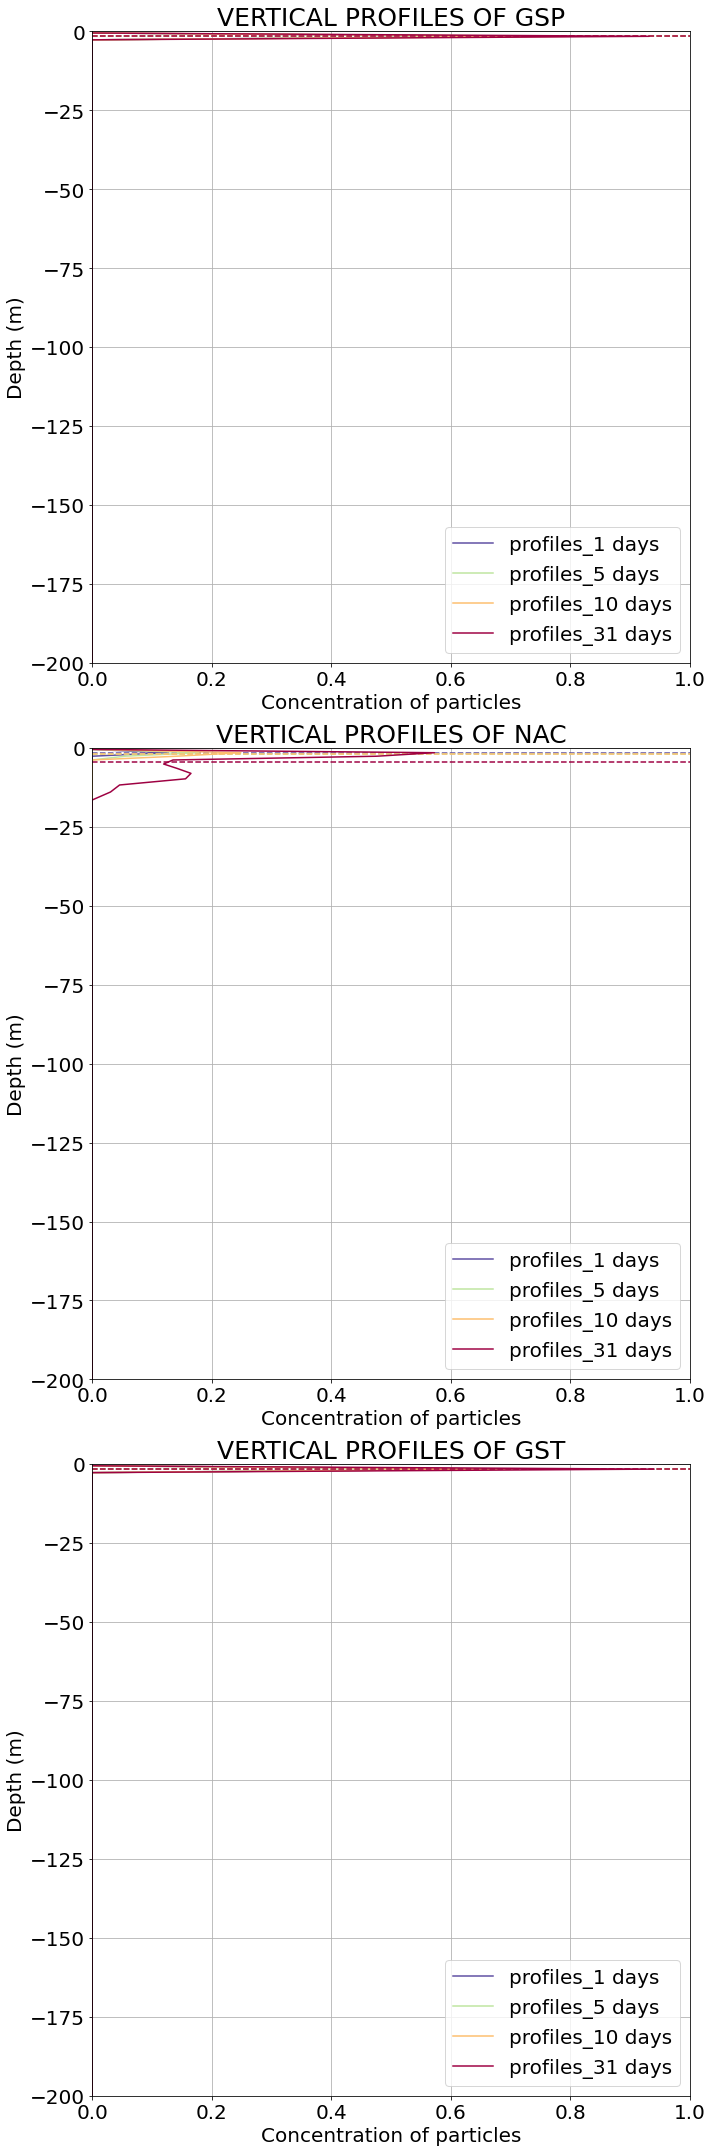

In [32]:
## Figure ##

cmap = plt.cm.Spectral_r
num_profiles = len(Time_array)
colors = [cmap(i) for i in np.linspace(0, 1, num_profiles)]

# Create separate plots for GSP, GS, and GST
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

# Plot data for GSP
for idx in range(num_profiles):
    key_p = Time_array[idx]
    ax1.plot(profiles[key_p,:,0]*0.22e14, -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    ax1.axhline(barycenter[key_p,0], linestyle='--', color=colors[idx])
ax1.set_ylabel('Depth (m)', fontsize=20)
ax1.set_xlabel('Concentration of particles', fontsize=20)
ax1.set_ylim(-200,0)
ax1.set_xlim(0,1)
ax1.grid()
ax1.legend(loc='lower right', fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('VERTICAL PROFILES OF GSP', fontsize=25)

# Plot data for GS
for idx in range(num_profiles):
    key_p = Time_array[idx]
    ax2.plot(profiles[key_p,:,1]*0.5e13, -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    ax2.axhline(barycenter[key_p,1], linestyle='--', color=colors[idx])
ax2.set_ylabel('Depth (m)', fontsize=20)
ax2.set_xlabel('Concentration of particles', fontsize=20)
ax2.set_ylim(-200,0)
ax2.set_xlim(0,1)
ax2.grid()
ax2.legend(loc='lower right', fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('VERTICAL PROFILES OF NAC', fontsize=25)

# Plot data for GST
for idx in range(num_profiles):
    key_p = Time_array[idx]
    ax3.plot(profiles[key_p,:,2]*4.1e13, -depth_values, label=f'profiles_{key_p} days', linewidth=1.5, color=colors[idx])
    ax3.axhline(barycenter[key_p,2], linestyle='--', color=colors[idx])
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.set_xlabel('Concentration of particles', fontsize=20)
ax3.set_ylim(-200,0)
ax3.set_xlim(0,1)
ax3.grid()
ax3.legend(loc='lower right',fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('VERTICAL PROFILES OF GST', fontsize=25)

# Customize the overall plot
#fig.suptitle('Vertical Profiles of Particle Distribution', fontsize=30)
plt.tight_layout()  # Add space for the suptitle
plt.savefig('Results/Zones_Vert_profiles_L.png')

In [16]:
barycenter_GST.shape

NameError: name 'barycenter_GST' is not defined

In [43]:
## Regression function for w*

barycenter_GSP = barycenter[:,0].reshape(-1, 1)
barycenter_GS  = barycenter[:,1].reshape(-1, 1)
barycenter_GST = barycenter[:,2].reshape(-1, 1)


w_GSP1, bary_pred_GSP1 = regression(barycenter_GSP[:91], time_scale[:91])
w_GS1, bary_pred_GS1 = regression(barycenter_GS[:15], time_scale[:15])
w_GST1, bary_pred_GST1 = regression(barycenter_GST[:250], time_scale[:250])

w_GSP2, bary_pred_GSP2 = regression(barycenter_GSP[91:], time_scale[91:])
w_GS2, bary_pred_GS2 = regression(barycenter_GS[15:], time_scale[15:])
w_GST2, bary_pred_GST2 = regression(barycenter_GST[250:], time_scale[250:])
print(f'For the first part: \n The w_GSP: {w_GSP1[0]:0.2}m/s \n The w_GS: {w_GS1[0]:0.2}m/s \n The w_GST: {w_GST1[0]:0.2}m/s')

## Figure ##

# Create separate plots for GSP, GS, and GST
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

# Plot data for GSP
ax1.plot(time_scale, barycenter_GSP, 'C0+', label='barycenter values')
ax1.plot(time_scale[91], barycenter_GSP[91], 'r+', label='slope discontinuity; day:91')
ax1.plot(time_scale[:91], bary_pred_GSP1, 'C1', label=f'Regression Curve; w={w_GSP1[0]:0.2}m/s')
ax1.plot(time_scale[91:], bary_pred_GSP2, 'C2', label=f'Regression Curve; w={w_GSP2[0]:0.2}m/s')
ax1.set_ylabel('Depth (m)', fontsize=20)
ax1.set_xlabel('Time (day)', fontsize=20)
ax1.grid()
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('VERTICAL DEPTH MEAN OF GSP', fontsize=25)

# Plot data for GS
ax2.plot(time_scale, barycenter_GS, 'C0+', label='barycenter values')
ax2.plot(time_scale[15], barycenter_GS[15], 'r+', label='slope discontinuity; day:15')
ax2.plot(time_scale[:15], bary_pred_GS1, 'C1', label=f'Regression Curve; w={w_GS1[0]:0.2}m/s')
ax2.plot(time_scale[15:], bary_pred_GS2, 'C2', label=f'Regression Curve; w={w_GS2[0]:0.2}m/s')
ax2.set_ylabel('Depth (m)', fontsize=20)
ax2.set_xlabel('Time (day)', fontsize=20)
ax2.grid()
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('VERTICAL DEPTH MEAN OF NAC', fontsize=25)

# Plot data for GST
ax3.plot(time_scale, barycenter_GST, 'C0+', label='barycenter values')
ax3.plot(time_scale[250], barycenter_GST[250], 'r+', label='slope discontinuity; day:250')
ax3.plot(time_scale[:250], bary_pred_GST1, 'C1', label=f'Regression Curve; w={w_GST1[0]:0.2}m/s')
ax3.plot(time_scale[250:], bary_pred_GST2, 'C2', label=f'Regression Curve; w={w_GST2[0]:0.2}m/s')
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.set_xlabel('Time (day)', fontsize=20)
ax3.grid()
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('VERTICAL DEPTH MEAN OF GST', fontsize=25)

# Customize the overall plot
#fig.suptitle('Vertical Profiles of Tracer Distribution', fontsize=30)
plt.tight_layout()  # Add space for the suptitle
plt.savefig('Results/Zones_w_L.png')

ValueError: Found input variables with inconsistent numbers of samples: [92, 250]

In [11]:
# Define subdomains
zone_1 = slice(0, 1356)
zone_2 = slice(1356, 3111)
zone_3 = slice(3111, 5986)

For the first part: 
 The k_GSP:4.5e-10 
 The k_GS:6.6e-06 
 The k_GST:9.6e-10
For the second part: 
 The k_GSP:3.4e-09 
 The k_GS:6.6e-06 
 The k_GST:9.6e-10


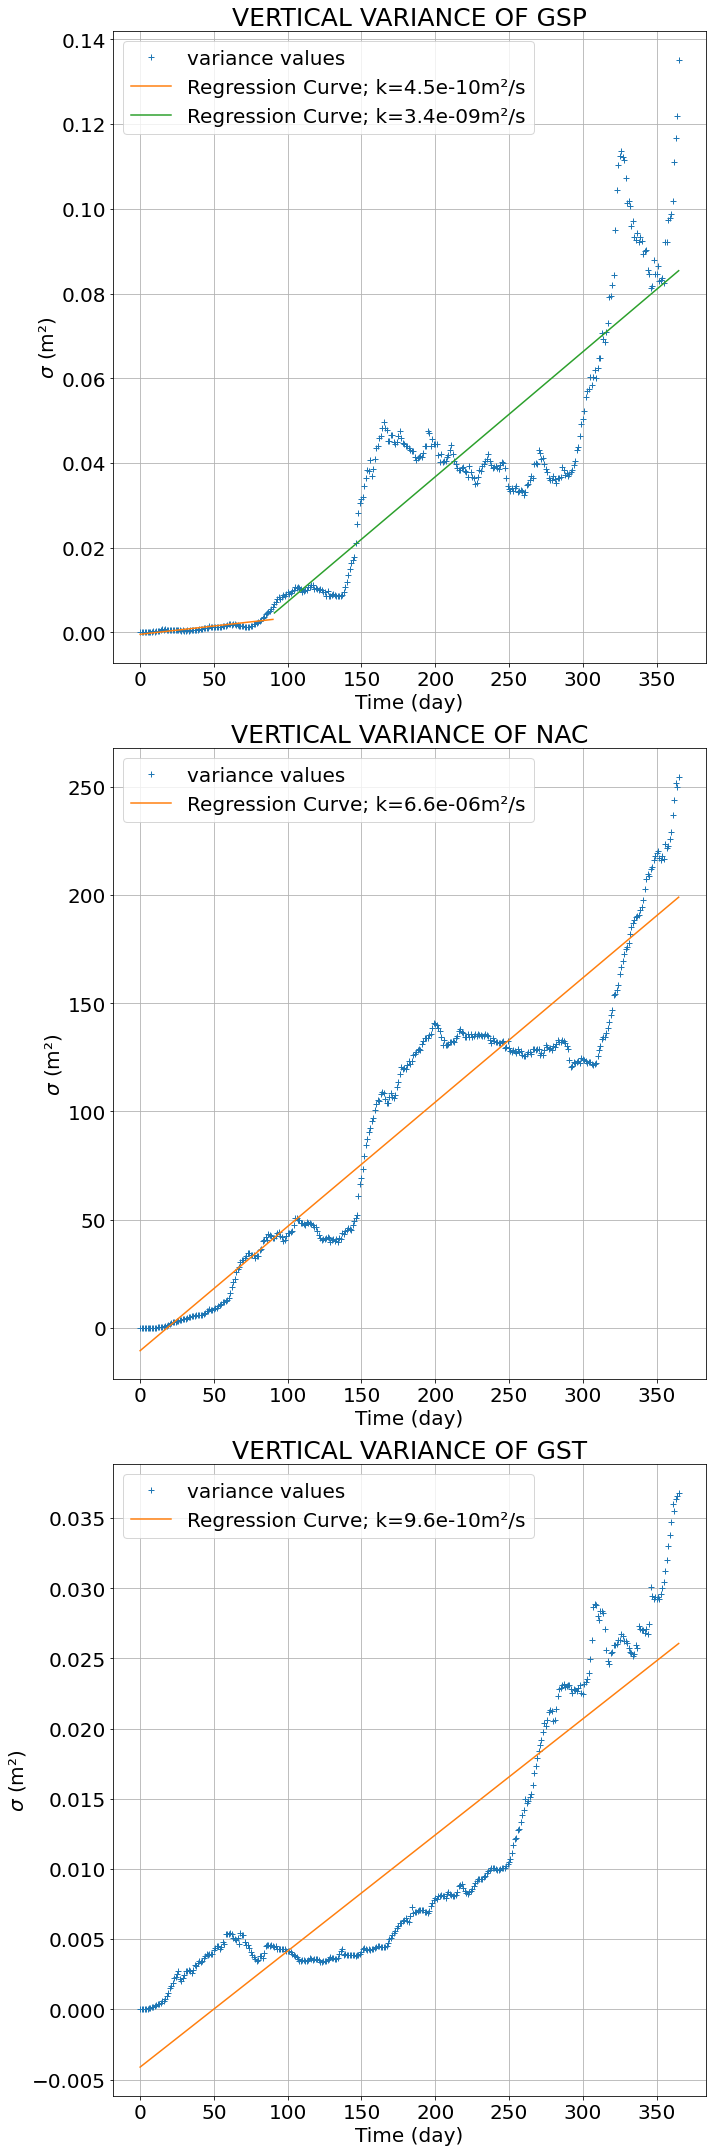

In [12]:
# Variance 

var_GSP = ds_zL.traj_depth[:,zone_1].var(dim=['ntraj'], skipna=True)
var_GS  = ds_zL.traj_depth[:,zone_2].var(dim=['ntraj'], skipna=True)
var_GST = ds_zL.traj_depth[:,zone_3].var(dim=['ntraj'], skipna=True)

# Regression curves for the variance 
k_GSP1, var_pred_GSP1 = regression(var_GSP[:91], time_scale[:91])
k_GS, var_pred_GS = regression(var_GS, time_scale)
k_GST, var_pred_GST = regression(var_GST, time_scale)

k_GSP2, var_pred_GSP2 = regression(var_GSP[91:], time_scale[91:])


print(f'For the first part: \n The k_GSP:{k_GSP1:0.2} \n The k_GS:{k_GS:0.2} \n The k_GST:{k_GST:0.2}')
print(f'For the second part: \n The k_GSP:{k_GSP2:0.2} \n The k_GS:{k_GS:0.2} \n The k_GST:{k_GST:0.2}')


## Figure ##
# Create separate plots for GSP, GS, and GST
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 30))

# Plot data for GSP
ax1.plot(time_scale, var_GSP, 'C0+', label='variance values')
ax1.plot(time_scale[:91], var_pred_GSP1, 'C1', label=f'Regression Curve; k={k_GSP1:0.2}m²/s')
ax1.plot(time_scale[91:], var_pred_GSP2, 'C2', label=f'Regression Curve; k={k_GSP2:0.2}m²/s')
ax1.set_ylabel('$\sigma$ (m²)', fontsize=20)
ax1.set_xlabel('Time (day)', fontsize=20)
ax1.grid()
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('VERTICAL VARIANCE OF GSP', fontsize=25)

# Plot data for GS
ax2.plot(time_scale, var_GS, 'C0+', label='variance values')
ax2.plot(time_scale, var_pred_GS, 'C1', label=f'Regression Curve; k={k_GS:0.2}m²/s')
#ax2.plot(time_scale[91:], var_pred_GS2, 'C2', label=f'Regression Curve; k={k_GS2:0.2}m²/s')
ax2.set_ylabel('$\sigma$ (m²)', fontsize=20)
ax2.set_xlabel('Time (day)', fontsize=20)
ax2.grid()
ax2.legend(fontsize=20)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('VERTICAL VARIANCE OF NAC', fontsize=25)

# Plot data for GST
ax3.plot(time_scale, var_GST, 'C0+', label='variance values')
ax3.plot(time_scale, var_pred_GST, 'C1', label=f'Regression Curve; k={k_GST:0.2}m²/s')
#ax3.plot(time_scale[91:], var_pred_GST2, 'C2', label=f'Regression Curve; k={k_GST2:0.2}m²/s')
ax3.set_ylabel('$\sigma$ (m²)', fontsize=20)
ax3.set_xlabel('Time (day)', fontsize=20)
ax3.grid()
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('VERTICAL VARIANCE OF GST', fontsize=25)

# Customize the overall plot
#fig.suptitle('Vertial variance of Tracer', fontsize=30)
plt.tight_layout()  # Add space for the suptitle
plt.savefig('Results/Zones_k_L.png')